In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
import torchvision
import torchvision.models as models
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
from PIL import ImageFile, Image
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import os, shutil, time
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf
import pandas as pd
import torchtext
import string

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print (device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Spanish Data Extraction


I started by reducing the downloaded Spanish data to 50MB locally then uploaded the data into coogle colab. 

In [ ]:
from google.colab import files
spanish_dict = files.upload()


Saving xaaSpanish.txt to xaaSpanish.txt


I decoded the text file using decode() function then  separated each sentence using split() function. 

In [ ]:
spanish_list = spanish_dict['xaaSpanish.txt'].decode("utf-8").split("\r\n")


I created a list of all sentences using splitlines() function.


In [ ]:
spanish_list_split = spanish_list[0].splitlines()

In [ ]:
spanish_list_split[:10]

['En el nombre de Alá el Compasivo el Misericordioso',
 'Alabado sea Alá Señor del universo',
 'Dueño del día del Juicio',
 'A Ti solo servimos y a Ti solo imploramos ayuda',
 'Dirígenos por la vía recta',
 'la vía de los que Tú has agraciado no de los que han incurrido en la ira ni de los extraviados',
 'Ésta es la Escritura exenta de dudas como dirección para los temerosos de Alá',
 'que creen en lo oculto hacen la azalá y dan limosna de lo que les hemos proveído',
 'creen en lo que se te ha revelado a ti y antes de ti y están convencidos de la otra vida',
 'Ésos son los dirigidos por su Señor y ésos los que prosperarán']

### English Data Extraction


In [ ]:
from google.colab import files
English_dict = files.upload()


Saving xaaEnglish.csv to xaaEnglish.csv


In [ ]:
English_dict['xaaEnglish.csv'][:100]

b'" \r\n = Polyozellus = \r\n \r\n Polyozellus is a fungal genus in the family Thelephoraceae , a grouping o'

Reading csv file using pandas 

In [ ]:
import pandas as pd
import io

English_data = io.StringIO(English_dict['xaaEnglish.csv'].decode("utf8"))

In [ ]:
Ensligh_data_pd = pd.read_csv(English_data, engine='python', encoding='utf8', error_bad_lines=False)


Skipping line 2905: unexpected end of data


I converted the pandas data frame to a list, then each item in the list is a sentence 

In [ ]:
from itertools import chain
English_list = Ensligh_data_pd.values.tolist()
English_list = list(chain(*English_list))
English_new_list = []
print(len(English_list))
for each_sentence in English_list:
    English_new_list.append(each_sentence.splitlines())
print(len(English_new_list))
English_new_list = list(chain(*English_new_list))
print(len(English_new_list))


2903
2903
174061


### Data Preprocessing

In data preprocessing, I converted the list of sentences to lower case and removed all punctuations except "." so the data only contains alphabet characters, whitespace, and periods. I also determined a set of unique characters ad mapped all characters to integers. 

In [ ]:
def dataPreprocessing(text_list, language = "Spanish"):
    # join characters and create a set of unique charaters 
    chars = set(''.join(text_list))
    
    # create a set of allowed punctuations
    if (language == "Spanish"):
        language_letters = set(['a', 'á', 'b', 'c', 'd', 'e', 'é', 'f', 'g', 'h', 'i', 'í', 'j', 'k', 'l', 'm', 'n', 'ñ','o', 'ó', 'p', 'q', 'r', 's', 't', 'u', 'ú', 'v', 'w', 'x', 'y', 'z'])
    elif (language == "English"):
        language_letters = set(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
    allowed = {".", " "}.union(language_letters)

    # a new filtered set that romves punctuations if they're not allowed 
    filtered_chars = set(''.join([letter for letter in chars if letter in allowed]))
    filtered_list = []
    for sentence in text_list:
        lower_sentence = sentence.lower()
        new_sentence = "".join([letter for letter in lower_sentence if letter in allowed])
        filtered_list.append(new_sentence.lower())
    # Dictionary to map ints to the characters
    int2char = dict(enumerate(filtered_chars))

    # Filp dictionary to map chars to ints 
    char2int = {char: intg for intg, char in int2char.items()}
    
    return filtered_list, char2int

In [ ]:
filtered_list_spanish, spanishChar2int = dataPreprocessing(spanish_list_split)
print(spanish_list_split[10:20])
print(filtered_list_spanish[10:20])
len(filtered_list_spanish)

['Da lo mismo que adviertas o no a los infieles no creen', 'Alá ha sellado sus corazones y oídos una venda cubre sus ojos y tendrán un castigo terrible', 'Hay entre los hombres quienes dicen Creemos en Alá y en el último Día pero no creen', 'Tratan de engañar a Alá y a los que creen pero sin darse cuenta sólo se engañan a sí mismos', 'Sus corazones están enfermos y Alá les ha agravado su enfermedad', 'Tendrán un castigo doloroso por haber mentido', 'Cuando se les dice No corrompáis en la tierra dicen Pero si somos reformadores', 'No son ellos en realidad los corruptores', 'Pero no se dan cuenta', 'Cuando se les dice Creed como creen los demás dicen Es que vamos a creer como creen los tontos']
['da lo mismo que adviertas o no a los infieles no creen', 'alá ha sellado sus corazones y oídos una venda cubre sus ojos y tendrán un castigo terrible', 'hay entre los hombres quienes dicen creemos en alá y en el último día pero no creen', 'tratan de engañar a alá y a los que creen pero sin darse

306041

In [ ]:
filtered_list_English, englishChar2int = dataPreprocessing(English_new_list, "English")
print(English_new_list[10:20])
print(filtered_list_English[10:20])
len(filtered_list_English)

[' The game uses an ad @-@ hoc online multiplayer feature that enables various actions between players , including trading Materia via email . Players can summon a friend to cast magic by filling the " Materia aid " meter . Up to three players can team up at any one time . " Rescue Mode " is activated if the player is defeated during " Episode Mode " , at which point they have the option to restart and lose points , or allow themselves to be imprisoned and wait for other players to rescue them . The player can be rescued while their phone is powered down . ', ' Additions were made after the initial release . In 2006 , a fighting arena dubbed " Battle Square " was added . In the " Battle Square " , players can either fight other players or AI @-@ controlled enemy units . Victory is determined by which side defeated the other and damage taken during combat . In " Battle Tournament " mode , players can choose to use a handicap : the handicap is determined randomly by a materia slot . Two 

174061

### Splitting the Data to Training and Validation Sets


Note that the Spanish list is larger than the English list

In [ ]:
min_len = min(len(filtered_list_spanish), len(filtered_list_English))
min_len = min_len//40 # I wanted less data because it kept taking all RAM space 
Spanish_train = filtered_list_spanish[:int(0.7*min_len)]
print(len(Spanish_train))
Spanish_valid = filtered_list_spanish[int(0.7*min_len):min_len]
print(len(Spanish_valid))
English_train = filtered_list_English[:int(0.7*min_len)]
print(len(English_train))
English_valid = filtered_list_English[int(0.7*min_len):min_len]
print(len(English_valid))


3045
1306
3045
1306


Converting each sentence into a fixed length. Easiest way to do this is to pad the small sentences with whitespace

In [ ]:
def padding(text_list1, text_list2):
    #print(len(max(text_list1, key=len)))
    #print(len(max(text_list2, key=len)))
    max_len = max(len(max(text_list1, key=len)), len(max(text_list2, key=len)))
    #print(max_len)
    for i in range(len(text_list1)):
      while len(text_list1[i])<max_len:
          text_list1[i] += ' '
      while len(text_list2[i])<max_len:
          text_list2[i] += ' '

    return text_list1, text_list2

In [ ]:
Spanish_train_fix_len, English_train_fix_len = padding(Spanish_train, English_train)
print(len(Spanish_train_fix_len))


3045


In [ ]:
Spanish_valid_fix_len, English_valid_fix_len = padding(Spanish_valid, English_valid)
print(len(Spanish_valid_fix_len))


1306


In [ ]:
type(Spanish_train_fix_len[0])

str

Not time to convert the strings to ints 

In [ ]:
def char2int(text, char2intDict):
  text_copy = text.copy()
  for i in range(len(text_copy)):
    text_copy[i] = [char2intDict[character] for character in text_copy[i]] 

  return text_copy

In [ ]:
Spanish_train_int = char2int(Spanish_train_fix_len, spanishChar2int) 

In [ ]:
English_train_int = char2int(English_train_fix_len, spanishChar2int) 


In [ ]:
Spanish_valid_int = char2int(Spanish_valid_fix_len, spanishChar2int) 

In [ ]:
English_valid_int = char2int(English_valid_fix_len, spanishChar2int) 


I like working with arrays more so I'm gonna do that :) 


In [ ]:
Y_train_spanish = np.zeros((len(Spanish_train_fix_len), 1))
print(len(Y_train_spanish))
Y_train_english = np.ones((len(English_train_fix_len), 1))
print(len(Y_train_english))
Y_valid_spanish = np.zeros((len(Spanish_valid_fix_len), 1))
Y_valid_english = np.ones((len(English_valid_fix_len), 1)) 
print(len(Y_valid_english))


3045
3045
1306


In [ ]:
'''English_train_int_arr = np.array(English_train_fix_len)
Spanish_train_int_arr = np.array(Spanish_train_fix_len)
train_arr = np.concatenate((English_train_int_arr, Spanish_train_int_arr), axis = 0)
Y_trin_arr = np.concatenate((Y_train_english, Y_train_spanish), axis = 0)



English_valid_int_arr = np.array(English_valid_fix_len)
Spanish_valid_int_arr = np.array(Spanish_valid_fix_len)
valid_arr = np.concatenate((English_valid_int_arr, Spanish_valid_int_arr), axis = 0).reshape((2612,1))
Y_valid_arr = np.concatenate((Y_valid_english, Y_valid_spanish), axis = 0)
print(Y_valid_arr.shape)
print(valid_arr.shape)

train_set = list(zip(train_arr, Y_trin_arr))
valid_set = list(zip(valid_arr, Y_valid_arr))'''

'English_train_int_arr = np.array(English_train_fix_len)\nSpanish_train_int_arr = np.array(Spanish_train_fix_len)\ntrain_arr = np.concatenate((English_train_int_arr, Spanish_train_int_arr), axis = 0)\nY_trin_arr = np.concatenate((Y_train_english, Y_train_spanish), axis = 0)\n\n\n\nEnglish_valid_int_arr = np.array(English_valid_fix_len)\nSpanish_valid_int_arr = np.array(Spanish_valid_fix_len)\nvalid_arr = np.concatenate((English_valid_int_arr, Spanish_valid_int_arr), axis = 0).reshape((2612,1))\nY_valid_arr = np.concatenate((Y_valid_english, Y_valid_spanish), axis = 0)\nprint(Y_valid_arr.shape)\nprint(valid_arr.shape)\n\ntrain_set = list(zip(train_arr, Y_trin_arr))\nvalid_set = list(zip(valid_arr, Y_valid_arr))'

In [ ]:
#.reshape(len(English_train_int),1)
English_train_int_arr = np.array(English_train_int)
Spanish_train_int_arr = np.array(Spanish_train_int)
train_arr = np.concatenate((English_train_int_arr, Spanish_train_int_arr), axis = 0)
Y_trin_arr = np.concatenate((Y_train_english, Y_train_spanish), axis = 0)



English_valid_int_arr = np.array(English_valid_int)
Spanish_valid_int_arr = np.array(Spanish_valid_int)
valid_arr = np.concatenate((English_valid_int_arr, Spanish_valid_int_arr), axis = 0)
Y_valid_arr = np.concatenate((Y_valid_english, Y_valid_spanish), axis = 0)
print(Y_valid_arr.shape)
print(valid_arr.shape)

train_set = list(zip(train_arr, Y_trin_arr))
valid_set = list(zip(valid_arr, Y_valid_arr))


(2612, 1)
(2612, 2089)


In [ ]:
'''Y_train_spanish = [0]*len(Spanish_train_fix_len)
Y_train_english = [1]*len(English_train_fix_len)
Y_valid_spanish = [0]*len(Spanish_valid_fix_len)
Y_valid_english = [1]*len(English_valid_fix_len) 

joined_Y_train = Y_train_english+Y_train_spanish
joined_Y_valid = Y_valid_english+Y_valid_spanish
train_set = list(zip(English_train_int+Spanish_train_int, joined_Y_train))
valid_set = list(zip(English_valid_int+Spanish_valid_int, joined_Y_valid))'''


'Y_train_spanish = [0]*len(Spanish_train_fix_len)\nY_train_english = [1]*len(English_train_fix_len)\nY_valid_spanish = [0]*len(Spanish_valid_fix_len)\nY_valid_english = [1]*len(English_valid_fix_len) \n\njoined_Y_train = Y_train_english+Y_train_spanish\njoined_Y_valid = Y_valid_english+Y_valid_spanish\ntrain_set = list(zip(English_train_int+Spanish_train_int, joined_Y_train))\nvalid_set = list(zip(English_valid_int+Spanish_valid_int, joined_Y_valid))'

In [ ]:
train_dl = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size = 10)
val_dl = torch.utils.data.DataLoader(valid_set, shuffle=True, batch_size = 10)

In [ ]:
loader_set = dict()
loader_set['train'] = train_dl
loader_set['val'] = val_dl

### Model


In [ ]:
class RNN(nn.Module):
    def __init__(self, dict_size = 34, hidden_siz = 4, num_layers = 1): # hidden size is random here 
        super(RNN, self).__init__()

        # Defining some parameters
        self.emb = nn.Embedding(num_embeddings = dict_size, embedding_dim = 34) 

        self.rnn = nn.RNN(input_size = 34, hidden_size = hidden_siz, num_layers = num_layers, batch_first=False)  # hidden_size is random 
        # Fully connected layer
        self.fc = nn.Linear(hidden_siz, 1)
    
    
    def forward(self, input): # input is batch x seq 
        embeds = self.emb(input)  # batch x seq x features 
        #print(embeds.size())
        embeds_swapped  = torch.transpose(embeds, 0, 1)
        #print(embeds_swapped.size())
        out_rnn, hidden = self.rnn(embeds_swapped) # rnn out = seqxbatchxhidden
        #print(('hidden', hidden.size()))
        #print(('out_rnn', out_rnn.size()))
        runn_last_out = out_rnn[-1] # batch*hidden
        
        out = self.fc(runn_last_out)
        scores = nn.functional.log_softmax(out, dim = 1)
        final_scores = torch.transpose(scores, 0, 1)
        #print(scores)
        return final_scores
    
   

In [ ]:
model = RNN() #

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.007, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    best_acc = 0.0
    val_loss_hist = []
    train_loss_hist = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels2 = torch.transpose(labels, 0, 1)
                    target = torch.argmax(labels2, 1)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs.float(), target.long())

                    #loss = torch.autograd.Variable(loss, requires_grad = True)
                   
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.10f} Acc: {:.10f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss_hist.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                if best_acc < epoch_acc:
                    best_acc = max(epoch_acc, best_acc)
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history, train_loss_hist, val_loss_hist

In [ ]:
model, val_acc_history, train_loss_hist, val_loss_hist = train_model(model, loader_set, criterion, optimizer, num_epochs=10)


cuda:0
Epoch 0/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 1/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 2/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 3/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0000000000

Epoch 4/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0000000000

Epoch 5/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0000000000

Epoch 6/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 7/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0000000000

Epoch 8/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 9/9
----------
train Loss: 2.3025

I'm not quite sure why I'm getting that the loss chnage is very small. perhapse because my data is bad. By that I mean I padded sentences with empty spaces such that all senteces become fixed length. Additionally, I needed to cut the data samples to less than 3k because otherwise I run out of RAM and colab crashes every 2min

In [ ]:
def plotLoss(train_loss_hist, val_loss_hist):
    plt.title("Training and Validation loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Training and Validation loss")
    plt.plot(range(len(train_loss_hist)),train_loss_hist,range(len(val_loss_hist)), val_loss_hist )
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

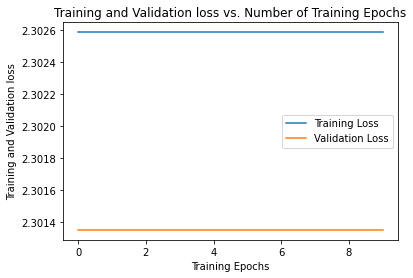

In [ ]:
plotLoss(train_loss_hist, val_loss_hist)

I experimented with the size of the hidden layer. I expected with larger size, more computation and it will take longer to train. It's still not making a change to my results :(

In [ ]:
model2 = RNN(hidden_siz = 18) #
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model2, val_acc_history2, train_loss_hist2, val_loss_hist2 = train_model(model2, loader_set, criterion, optimizer, num_epochs=10)


cuda:0
Epoch 0/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 1/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 2/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0000000000

Epoch 3/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 4/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 5/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 6/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 7/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 8/9
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0003828484

Epoch 9/9
----------
train Loss: 2.3025

I also tried changing the number of layers 


In [ ]:
model3 = RNN(hidden_siz = 18, num_layers=3) #
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model3, val_acc_history3, train_loss_hist3, val_loss_hist3 = train_model(model3, loader_set, criterion, optimizer, num_epochs=3)


cuda:0
Epoch 0/2
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 1/2
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Epoch 2/2
----------
train Loss: 2.3025851250 Acc: 0.0000000000
val Loss: 2.3013527835 Acc: 0.0007656968

Training complete in 7m 7s
Best val Acc: 0.000766


Even changing the those parameters didn't change the loss or accuracy. My guess is that my data needs to be larger. I really tried to do that but colb crashes even if I increase a little more. I'm sorry :( I also believe that the padded method I used is what is expected for part 2. I just noticed :( 